# GP_extras for Heteroscedastic Kernels (non constant variance)
From ```https://github.com/jmetzen/gp_extras```

This code re implements the example given in the github above. Noise are meant to be increasing quadraticaly.
But in this implementation, there is no errorbar, only observations that are affected by the changing noise.

So in this implementation, info/data from the errorbars are not considered. Only the observations are considered. ```Prototypes``` cluster the observations to represent some sort of heteroscedasity?

Xshape:(100,),yshape:(100,)
<class 'numpy.ndarray'>


c:\Users\shahr\code\.mlenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


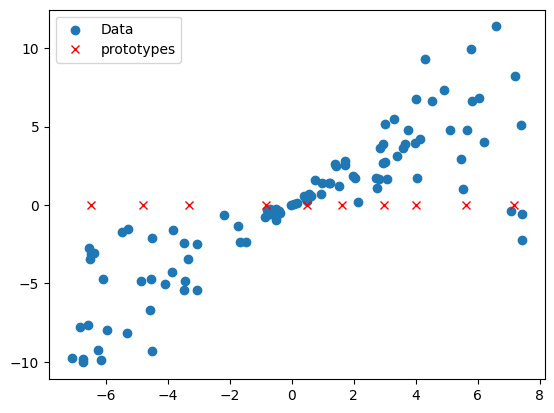

In [19]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.cluster import KMeans


# Generate data
n_samples = 100
def f(X):
    # target function is just a linear relationship + heteroscadastic noise
    return X + 0.5*np.random.multivariate_normal(np.zeros(X.shape[0]),
                                                 np.diag(X**2), 1)[0]

X = np.random.uniform(-7.5, 7.5, n_samples)  # input data
y = f(X)  # Generate target values by applying function to manifold
# Gaussian Process with RBF kernel and heteroscedastic noise level


print(f'Xshape:{X.shape},yshape:{y.shape}')
print(type(X))
prototypes = KMeans(n_clusters=10).fit(X[:, np.newaxis]).cluster_centers_

plt.scatter(X,y)
plt.plot(prototypes,np.zeros_like(prototypes),'x', color='red')
plt.legend(['Data','prototypes'])
plt.show()
#x_dummy = np.linspace(1,10,10)
#x_dummy.shape


## Heteroscedastic Kernel Class

In [20]:
from sklearn.gaussian_process.kernels import Kernel, _approx_fprime, Hyperparameter, RBF, pairwise_kernels

class HeteroscedasticKernel(Kernel):

    """Kernel which learns a heteroscedastic noise model.

    This kernel learns for a set of prototypes values from the data space
    explicit noise levels. These exemplary noise levels are then generalized to
    the entire data space by means for kernel regression.

    Parameters
    ----------
    prototypes : array-like, shape = (n_prototypes, n_X_dims)
        Prototypic samples from the data space for which noise levels are
        estimated.

    sigma_2 : float, default: 1.0
        Parameter controlling the initial noise level

    sigma_2_bounds : pair of floats >= 0, default: (0.1, 10.0)
        The lower and upper bound on sigma_2

    gamma : float, default: 1.0
        Length scale of the kernel regression on the noise level

    gamma_bounds : pair of floats >= 0, default: (1e-2, 1e2)
        The lower and upper bound on gamma
    """
    def __init__(self, prototypes, sigma_2=1.0, sigma_2_bounds=(0.1, 10.0),
                 gamma=1.0, gamma_bounds=(1e-2, 1e2)):
        assert prototypes.shape[0] == sigma_2.shape[0]
        self.prototypes = prototypes

        self.sigma_2 = np.asarray(sigma_2)
        self.sigma_2_bounds = sigma_2_bounds

        self.gamma = gamma
        self.gamma_bounds = gamma_bounds

        self.hyperparameter_sigma_2 = \
                Hyperparameter("sigma_2", "numeric", self.sigma_2_bounds,
                               self.sigma_2.shape[0])

        self.hyperparameter_gamma = \
                Hyperparameter("gamma", "numeric", self.gamma_bounds)

    @classmethod
    def construct(cls, prototypes, sigma_2=1.0, sigma_2_bounds=(0.1, 10.0),
                  gamma=1.0, gamma_bounds=(1e-2, 1e2)):
        prototypes = np.asarray(prototypes)
        if prototypes.shape[0] > 1 and len(np.atleast_1d(sigma_2)) == 1:
            sigma_2 = np.repeat(sigma_2, prototypes.shape[0])
            sigma_2_bounds = np.vstack([sigma_2_bounds] *prototypes.shape[0])
        return cls(prototypes, sigma_2, sigma_2_bounds, gamma, gamma_bounds)

    def __call__(self, X, Y=None, eval_gradient=False):
        """Return the kernel k(X, Y) and optionally its gradient.

        Parameters
        ----------
        X : array, shape (n_samples_X, n_features)
            Left argument of the returned kernel k(X, Y)

        Y : array, shape (n_samples_Y, n_features), (optional, default=None)
            Right argument of the returned kernel k(X, Y). If None, k(X, X)
            if evaluated instead.

        eval_gradient : bool (optional, default=False)
            Determines whether the gradient with respect to the kernel
            hyperparameter is determined. Only supported when Y is None.

        Returns
        -------
        K : array, shape (n_samples_X, n_samples_Y)
            Kernel k(X, Y)

        K_gradient : array (opt.), shape (n_samples_X, n_samples_X, n_dims)
            The gradient of the kernel k(X, X) with respect to the
            hyperparameter of the kernel. Only returned when eval_gradient
            is True.
        """
        prototypes_std = self.prototypes.std(0)
        n_prototypes = self.prototypes.shape[0]
        n_gradient_dim = \
            n_prototypes + (0 if self.hyperparameter_gamma.fixed else 1)

        X = np.atleast_2d(X)
        if Y is not None and eval_gradient:
            raise ValueError("Gradient can only be evaluated when Y is None.")

        if Y is None:
            K= np.eye(X.shape[0]) * self.diag(X)
            if eval_gradient:
                K_gradient = \
                    np.zeros((K.shape[0], K.shape[0], n_gradient_dim))
                K_pairwise = \
                    pairwise_kernels(self.prototypes / prototypes_std,
                                     X / prototypes_std,
                                     metric="rbf", gamma=self.gamma)
                for i in range(n_prototypes):
                    for j in range(K.shape[0]):
                        K_gradient[j, j, i] = \
                            self.sigma_2[i] * K_pairwise[i, j] \
                            / K_pairwise[:, j].sum()
                if not self.hyperparameter_gamma.fixed:
                    # XXX: Analytic expression for gradient?
                    def f(gamma):  # helper function
                        theta = self.theta.copy()
                        theta[-1] = gamma[0]
                        return self.clone_with_theta(theta)(X, Y)
                    K_gradient[:, :, -1] = \
                        _approx_fprime([self.theta[-1]], f, 1e-5)[:, :, 0]
                return K, K_gradient
            else:
                return K
        else:
            K = np.zeros((X.shape[0], Y.shape[0]))
            return K   # XXX: similar entries?

    def is_stationary(self):
        """Returns whether the kernel is stationary. """
        return False

    def diag(self, X):
        """Returns the diagonal of the kernel k(X, X).

        The result of this method is identical to np.diag(self(X)); however,
        it can be evaluated more efficiently since only the diagonal is
        evaluated.

        Parameters
        ----------
        X : array, shape (n_samples_X, n_features)
            Left argument of the returned kernel k(X, Y)

        Returns
        -------
        K_diag : array, shape (n_samples_X,)
            Diagonal of kernel k(X, X)
        """
        prototypes_std = self.prototypes.std(0)
        n_prototypes = self.prototypes.shape[0]

        # kernel regression of noise levels
        K_pairwise = \
            pairwise_kernels(self.prototypes / prototypes_std,
                             X / prototypes_std,
                             metric="rbf", gamma=self.gamma)

        return (K_pairwise * self.sigma_2[:, None]).sum(axis=0) \
                / K_pairwise.sum(axis=0)

    def __repr__(self):
        return "{0}(sigma_2=[{1}], gamma={2})".format(self.__class__.__name__,
            ", ".join(map("{0:.3g}".format, self.sigma_2)), self.gamma)

## Fit

In [21]:
kernel_hetero = C(1.0, (1e-10, 1000)) * RBF(1, (0.01, 100.0)) \
    + HeteroscedasticKernel.construct(prototypes, 1e-3, (1e-10, 50.0),
                                      gamma=5.0, gamma_bounds="fixed")
gp_heteroscedastic = GaussianProcessRegressor(kernel=kernel_hetero, alpha=0)
gp_heteroscedastic.fit(X[:, np.newaxis], y)
print(f"Heteroscedastic kernel: {gp_heteroscedastic.kernel_}")
print(f"Heteroscedastic LML: {gp_heteroscedastic.log_marginal_likelihood(gp_heteroscedastic.kernel_.theta)}")

print(X[:, np.newaxis].shape)


Heteroscedastic kernel: 7.63**2 * RBF(length_scale=12) + HeteroscedasticKernel(sigma_2=[1.52e-08, 38.4, 7.24, 1e-10, 10.6, 2.03, 1.18e-08, 0.775, 6.19, 9.2e-09], gamma=5.0)
Heteroscedastic LML: -178.24350223803293
(100, 1)


c:\Users\shahr\code\.mlenv\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 3 of parameter k2__sigma_2 is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


## Plot

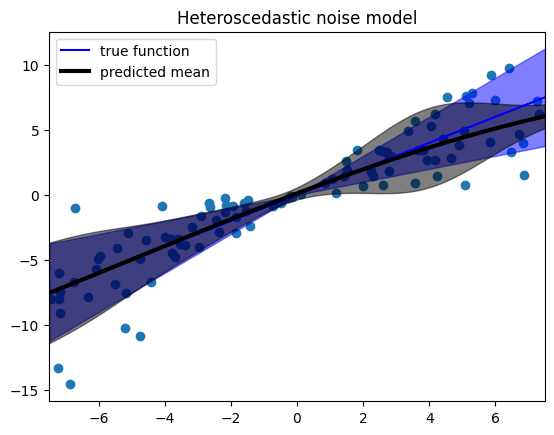

In [4]:
# Plot result
X_ = np.linspace(-7.5, 7.5, 100)
y_ = X_
noise_std = 0.5 * X_

plt.scatter(X, y)
plt.plot(X_, y_, 'b', label="true function")
plt.fill_between(X_, y_ - noise_std, y_ + noise_std,
                 alpha=0.5, color='b')
y_mean, y_std = gp_heteroscedastic.predict(X_[:, None], return_std=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9, label="predicted mean")
plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                 alpha=0.5, color='k')
plt.xlim(-7.5, 7.5)
plt.legend(loc="best")
plt.title("Heteroscedastic noise model")
plt.show()